#Importing Libraries & Setup

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the file
!unzip /content/drive/MyDrive/trashClassifier/realwaste.zip -d /content/realwaste

# Verify the folder structure
import os
data_dir = '/content/realwaste'
classes = os.listdir(data_dir)
print("Classes found:", classes)

Streaming output truncated to the last 5000 lines.
  inflating: /content/realwaste/__MACOSX/realwaste/RealWaste/Recyclable/._Plastic_408.jpg  
  inflating: /content/realwaste/realwaste/RealWaste/Recyclable/Glass_145.jpg  
  inflating: /content/realwaste/__MACOSX/realwaste/RealWaste/Recyclable/._Glass_145.jpg  
  inflating: /content/realwaste/realwaste/RealWaste/Recyclable/Cardboard_115.jpg  
  inflating: /content/realwaste/__MACOSX/realwaste/RealWaste/Recyclable/._Cardboard_115.jpg  
  inflating: /content/realwaste/realwaste/RealWaste/Recyclable/Cardboard_61.jpg  
  inflating: /content/realwaste/__MACOSX/realwaste/RealWaste/Recyclable/._Cardboard_61.jpg  
  inflating: /content/realwaste/realwaste/RealWaste/Recyclable/Cardboard_75.jpg  
  inflating: /content/realwaste/__MACOSX/realwaste/RealWaste/Recyclable/._Cardboard_75.jpg  
  inflating: /content/realwaste/realwaste/RealWaste/Recyclable/Glass_151.jpg  
  inflating: /content/realwaste/__MACOSX/realwaste/RealWaste/Recyclable/._Glass_15

#Image Shuffling & Resizing

In [4]:
import os
import random
from pathlib import Path

# Path to the extracted realwaste folder
dataset_path = '/content/realwaste/realwaste/RealWaste'  # Update this to the correct path
categories = ["Trash", "Compostable", "Recyclable"]  # Folder names

# Shuffle and rename images
for category in categories:
    category_path = os.path.join(dataset_path, category)  # Corrected to use os.path.join

    # Get all image files in the folder
    images = list(Path(category_path).glob("*"))

    # Shuffle the list of images
    random.shuffle(images)

    # Rename images with numbers
    for idx, image_path in enumerate(images, start=1):
        new_name = Path(category_path) / f"{idx}{image_path.suffix}"  # Retain the original file extension
        image_path.rename(new_name)

print("Images have been shuffled and renamed!")


Images have been shuffled and renamed!


In [6]:
import os
from PIL import Image

# Path to dataset
dataset_path = '/content/realwaste/realwaste/RealWaste'

# Check for corrupted images
corrupted_images = []
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify image is not corrupted
            except (IOError, SyntaxError):
                corrupted_images.append(img_path)

# Report and remove corrupted images
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images. Removing them...")
    for corrupted_file in corrupted_images:
        os.remove(corrupted_file)
else:
    print("No corrupted images found!")


No corrupted images found!


#Data Augmentation & Spliting

In [7]:
from PIL import Image

# Resize all images in the dataset to 128x128
IMG_HEIGHT, IMG_WIDTH = 128, 128

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                # Open, resize, and save the image
                img = Image.open(img_path)
                img = img.resize((IMG_WIDTH, IMG_HEIGHT))
                img.save(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print("All images have been resized to 128x128 pixels.")


All images have been resized to 128x128 pixels.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Rotate the image by up to 30 degrees
    width_shift_range=0.2,  # Shift the image horizontally by up to 20% of width
    height_shift_range=0.2,  # Shift the image vertically by up to 20% of height
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out by up to 20%
    horizontal_flip=True,  # Flip the image horizontally
    fill_mode='nearest'  # Fill any gaps created by transformations
)

print("Data augmentation setup is complete.")


Data augmentation setup is complete.


In [10]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Update ImageDataGenerator with preprocess_input for normalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Standardize to ImageNet's mean/std
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Recreate data generators
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Pixel normalization to ImageNet mean and std completed.")


Found 3803 images belonging to 3 classes.
Found 949 images belonging to 3 classes.
Found 4752 images belonging to 3 classes.
Pixel normalization to ImageNet mean and std completed.


In [11]:
# Print sizes of the splits
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Testing samples: {test_data.samples}")

# Class indices
print(f"Class Indices: {train_data.class_indices}")


Training samples: 3803
Validation samples: 949
Testing samples: 4752
Class Indices: {'Compostable': 0, 'Recyclable': 1, 'Trash': 2}


#Creating a Base CNN Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening layer
    Flatten(),

    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    Dense(3, activation='softmax')  # 6 classes
])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Testing the base model using optimizer and early stopping

In [13]:
from tensorflow.keras.optimizers import Adam

# Compile the CNN model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate can be tuned
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

print("Model compiled successfully.")


Model compiled successfully.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Updated file extension to .keras
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # You can increase if needed
    callbacks=[early_stopping, model_checkpoint]
)

print("Model training complete.")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.5915 - loss: 13.3662 - val_accuracy: 0.6512 - val_loss: 0.8835
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.6461 - loss: 0.8271 - val_accuracy: 0.6596 - val_loss: 0.7099
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.6744 - loss: 0.7530 - val_accuracy: 0.7313 - val_loss: 0.7366
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.7056 - loss: 0.7421 - val_accuracy: 0.7418 - val_loss: 0.6834
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.7296 - loss: 0.7032 - val_accuracy: 0.7302 - val_loss: 0.7852
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.7379 - loss: 0.6910 - val_accuracy: 0.7545 - val_loss: 0.6168
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.7503 - loss: 0.6623 - val_accuracy: 0.7366 - val_loss: 0.6691
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.7303 - loss: 0.6724 - va

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8856 - loss: 0.4215
Test Accuracy: 0.7795
Test Loss: 0.5388


In [16]:
# Save the model to a file
model.save("final_trashnet_model.keras")
print("Model saved as final_trashnet_model.keras")


Model saved as final_trashnet_model.keras


In [17]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Get test images and labels
test_images, test_labels = next(iter(test_data))

# Make predictions
predictions = model.predict(test_images)

# Convert predictions and labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Display a few results
for i in range(5):
    print(f"True Class: {true_classes[i]}, Predicted Class: {predicted_classes[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0
True Class: 0, Predicted Class: 0


#Training model by using class weights and updating early stoppage

In [18]:
import os
from collections import Counter

# Count the number of images in each class
class_counts = Counter()
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print class counts
print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Class Distribution:
Compostable: 847
Recyclable: 3092
Trash: 813


In [19]:
from sklearn.utils import class_weight
import numpy as np

# Generate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Balances based on class distribution
    classes=np.unique(list(train_data.class_indices.values())),  # Class indices
    y=train_data.classes  # Training labels
)

# Convert to a dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.8697148475909537, 1: 0.5123955807060092, 2: 1.9472606246799795}


In [20]:
# Train the model with class weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Adjust if needed
    class_weight=class_weights_dict,  # Add class weights here
    callbacks=[early_stopping, model_checkpoint]
)

print("Model retraining with class weights complete.")


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.7126 - loss: 0.8139 - val_accuracy: 0.7366 - val_loss: 0.7068
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6183 - loss: 0.9035 - val_accuracy: 0.5395 - val_loss: 0.9564
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.6132 - loss: 0.8976 - val_accuracy: 0.7597 - val_loss: 0.6152
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.6543 - loss: 0.7716 - val_accuracy: 0.7323 - val_loss: 0.7068
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6089 - loss: 0.7935 - val_accuracy: 0.7661 - val_loss: 0.6309
Model retraining with class weights complete.


In [21]:
# Define updated early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Retrain the model with updated early stopping
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Total epochs to allow more training
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

print("Model retraining with updated early stopping complete.")


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6333 - loss: 0.8555 - val_accuracy: 0.7492 - val_loss: 0.7099
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.6667 - loss: 0.8063 - val_accuracy: 0.7439 - val_loss: 0.6535
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.6435 - loss: 0.8101 - val_accuracy: 0.5543 - val_loss: 1.0940
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.5626 - loss: 0.9525 - val_accuracy: 0.7229 - val_loss: 0.7083
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.6446 - loss: 0.7966 - val_accuracy: 0.7144 - val_loss: 0.6793
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.6374 - loss: 0.7410 - val_accuracy: 0.6997 - val_loss: 0.7166
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.5239 - loss: 0.8734 - val_accuracy: 0.6017 - val_loss: 0.8379
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.6039 - loss: 0

#Creating a ResNet50 CNN model

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(3, activation='softmax')(x)  # Final output layer for 6 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate if necessary
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
# Retrain the transfer learning model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # You can adjust this if necessary
    class_weight=class_weights_dict,  # Use class weights to handle imbalance
    callbacks=[early_stopping, model_checkpoint]
)

print("Model retraining with transfer learning complete.")


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.6828 - loss: 0.9555 - val_accuracy: 0.8430 - val_loss: 0.3815
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.8450 - loss: 0.3990 - val_accuracy: 0.8820 - val_loss: 0.3075
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8383 - loss: 0.3877 - val_accuracy: 0.8841 - val_loss: 0.3223
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - accuracy: 0.8534 - loss: 0.3472 - val_accuracy: 0.9073 - val_loss: 0.2634
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.8613 - loss: 0.3124 - val_accuracy: 0.8999 - val_loss: 0.2571
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.8850 - loss: 0.3005 - val_accuracy: 0.8820 - val_loss: 0.2858
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.8588 - loss: 0.3149 - val_accuracy: 0.8830 - val_loss: 0.2846
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.8958 - loss: 0

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9683 - loss: 0.0918
Test Accuracy: 0.9524
Test Loss: 0.1350


In [25]:
# Save the final trained model
model.save("final_trashnet_transfer_learning_model.keras")
print("Final model saved.")


Final model saved.


#Defined ReduceLROnPlateau on the ResNet Transfer Learning model

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait for 3 epochs of no improvement
    min_lr=1e-6  # Minimum learning rate
)

# Retrain the model with ReduceLROnPlateau
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,  # Use class weights
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("Model retraining with learning rate scheduler complete.")


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9016 - loss: 0.2346 - val_accuracy: 0.9315 - val_loss: 0.2049 - learning_rate: 0.0010
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9190 - loss: 0.1982 - val_accuracy: 0.9294 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9135 - loss: 0.2375 - val_accuracy: 0.9220 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9121 - loss: 0.2261 - val_accuracy: 0.9326 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9249 - loss: 0.1939 - val_accuracy: 0.9273 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9158 - loss: 0.1975 - val_accuracy: 0.9315 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9

In [27]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9720 - loss: 0.0835
Test Accuracy: 0.9548
Test Loss: 0.1233


#Tested out Batch sizes 16 and 64

In [28]:
# Smaller batch size
BATCH_SIZE = 16

# Recreate data generators with smaller batch size
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Retrain the model
history_small_batch = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("Model retraining with smaller batch size complete.")


Found 3803 images belonging to 3 classes.
Found 949 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


238/238 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.9266 - loss: 0.1769 - val_accuracy: 0.9336 - val_loss: 0.2022 - learning_rate: 2.5000e-04
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9288 - loss: 0.1646 - val_accuracy: 0.9283 - val_loss: 0.2083 - learning_rate: 2.5000e-04
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9290 - loss: 0.1685 - val_accuracy: 0.9315 - val_loss: 0.2086 - learning_rate: 2.5000e-04
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9499 - loss: 0.1370 - val_accuracy: 0.9326 - val_loss: 0.2130 - learning_rate: 2.5000e-04
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.9433 - loss: 0.1416 - val_accuracy: 0.9315 - val_loss: 0.2175 - learning_rate: 1.2500e-04
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9457 - loss: 0.1428 - val_accuracy: 0.9368 - val_loss: 0.2127 - learning_rate: 1.2500e-04
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accurac

In [29]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9720 - loss: 0.0824
Test Accuracy: 0.9592
Test Loss: 0.1160


In [30]:
model.save("final_trashnet_small_batch_model.keras")
print("Final model saved.")


Final model saved.


In [31]:
# Larger batch size
BATCH_SIZE = 64

# Recreate data generators with larger batch size
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Retrain the model with the larger batch size
history_large_batch = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print("Model retraining with larger batch size complete.")


Found 3803 images belonging to 3 classes.
Found 949 images belonging to 3 classes.
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.9386 - loss: 0.1722 - val_accuracy: 0.9326 - val_loss: 0.1997 - learning_rate: 3.1250e-05
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 248ms/step - accuracy: 0.9342 - loss: 0.1794 - val_accuracy: 0.9336 - val_loss: 0.1982 - learning_rate: 3.1250e-05
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9348 - loss: 0.1554 - val_accuracy: 0.9336 - val_loss: 0.1986 - learning_rate: 3.1250e-05
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step - accuracy: 0.9337 - loss: 0.1557 - val_accuracy: 0.9347 - val_loss: 0.1979 - learning_rate: 3.1250e-05
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step - accuracy: 0.9350 - loss: 0.1609 - val_accuracy: 0.9347 - val_loss: 0.1978 - learning_rate: 3.1250e-05
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 248ms/step - accuracy: 0.9327 - loss: 0.1604 - val_accuracy: 0.9336 - val_loss: 0.1975 - l

In [32]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9699 - loss: 0.0841
Test Accuracy: 0.9590
Test Loss: 0.1181


In [33]:
model.save("final_trashnet_model_large_batch.keras")
print("Final model saved.")


Final model saved.


#Added learning rates

In [34]:
learning_rates = [0.001, 0.0005, 0.0001]

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_lr = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, model_checkpoint]
    )
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Training with learning rate: 0.001
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.9315 - loss: 0.1971 - val_accuracy: 0.9220 - val_loss: 0.2247
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.9199 - loss: 0.1884 - val_accuracy: 0.9262 - val_loss: 0.2155
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9163 - loss: 0.1986 - val_accuracy: 0.9189 - val_loss: 0.2254
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 248ms/step - accuracy: 0.9142 - loss: 0.1892 - val_accuracy: 0.9389 - val_loss: 0.1947
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9267 - loss: 0.1794 - val_accuracy: 0.9389 - val_loss: 0.1985
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9320 - loss: 0.1613 - val_accuracy: 0.9336 - val_loss: 0.2141
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9397 - loss: 0.1511 - val_accuracy: 0.9368 - val_loss: 0.2201
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accurac

In [35]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_final = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)


model.save("final_trashnet_tuned_model.keras")
print("Final model saved.")


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 339ms/step - accuracy: 0.9476 - loss: 0.1284 - val_accuracy: 0.9368 - val_loss: 0.2205
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9368 - loss: 0.1465 - val_accuracy: 0.9347 - val_loss: 0.2086
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9352 - loss: 0.1519 - val_accuracy: 0.9378 - val_loss: 0.2075
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9498 - loss: 0.1261 - val_accuracy: 0.9378 - val_loss: 0.2015
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.9429 - loss: 0.1347 - val_accuracy: 0.9378 - val_loss: 0.1990
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9497 - loss: 0.1122 - val_accuracy: 0.9336 - val_loss: 0.2040
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9519 - loss: 0.1186 - val_accuracy: 0.9378 - val_loss: 0.2073
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9514 - loss: 0.1266 - val_accu

In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9726 - loss: 0.0720
Test Accuracy: 0.9628, Test Loss: 0.1031


#Optimizer Tuning to see which one works best

In [37]:
from tensorflow.keras.optimizers import SGD, RMSprop

# Define optimizers to test
optimizers = {
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
}

# Loop through optimizers
for optimizer_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {optimizer_name}")
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_optimizer = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, model_checkpoint]
    )
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"Optimizer: {optimizer_name}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Training with optimizer: SGD
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.9392 - loss: 0.1517 - val_accuracy: 0.9315 - val_loss: 0.2286
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.9249 - loss: 0.1908 - val_accuracy: 0.9305 - val_loss: 0.2468
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.9304 - loss: 0.1782 - val_accuracy: 0.9357 - val_loss: 0.2452
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9309 - loss: 0.1788 - val_accuracy: 0.9389 - val_loss: 0.2330
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.9309 - loss: 0.1621 - val_accuracy: 0.9294 - val_loss: 0.2697
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9304 - loss: 0.1711 - val_accuracy: 0.9336 - val_loss: 0.2382
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.9311 - loss: 0.1618 - val_accuracy: 0.9231 - val_loss: 0.2476
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.9

In [38]:
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_final_sgd = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Optimizer: {optimizer_name}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
model.save("final_trashnet_sgd_model.keras")
print("Final model saved with SGD optimizer.")

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.9407 - loss: 0.1376 - val_accuracy: 0.9347 - val_loss: 0.2269
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.9213 - loss: 0.2141 - val_accuracy: 0.9399 - val_loss: 0.2133
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9435 - loss: 0.1493 - val_accuracy: 0.9399 - val_loss: 0.2279
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9326 - loss: 0.1577 - val_accuracy: 0.9336 - val_loss: 0.2224
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9150 - loss: 0.2117 - val_accuracy: 0.9378 - val_loss: 0.2400
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9283 - loss: 0.1984 - val_accuracy: 0.9357 - val_loss: 0.2221
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9285 - loss: 0.1657 - val_accuracy: 0.9368 - val_loss: 0.2200
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.9275 - loss: 0.1762 - val_accu

#Performance Metrics & Visualizations to understand Misclassifications

149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step
Classification Report:
              precision    recall  f1-score   support

 Compostable       0.95      0.98      0.97       847
  Recyclable       0.98      0.97      0.98      3092
       Trash       0.92      0.90      0.91       813

    accuracy                           0.96      4752
   macro avg       0.95      0.95      0.95      4752
weighted avg       0.96      0.96      0.96      4752



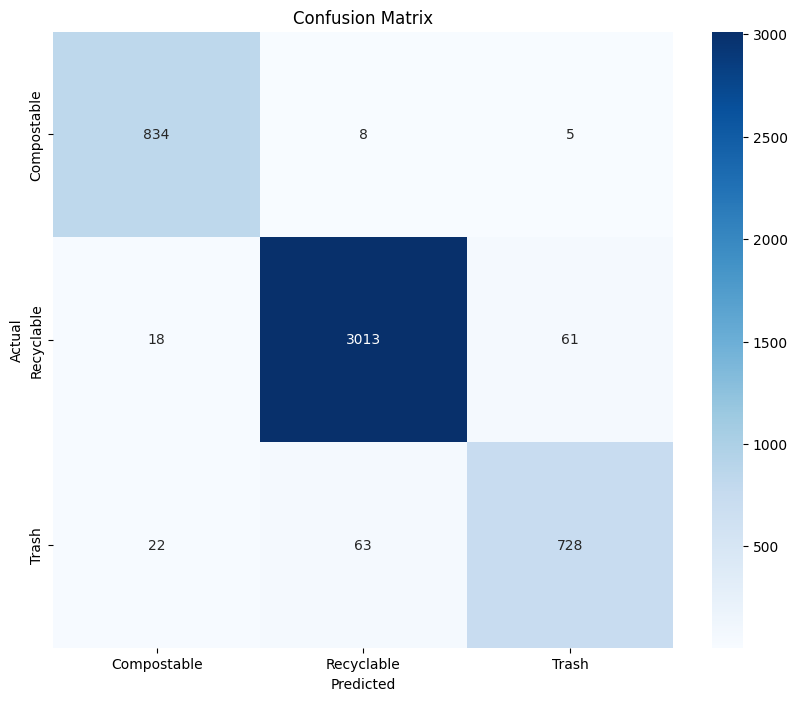

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions
true_labels = test_data.classes  # Ground truth
predictions = model.predict(test_data, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Compute classification metrics
class_names = list(test_data.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


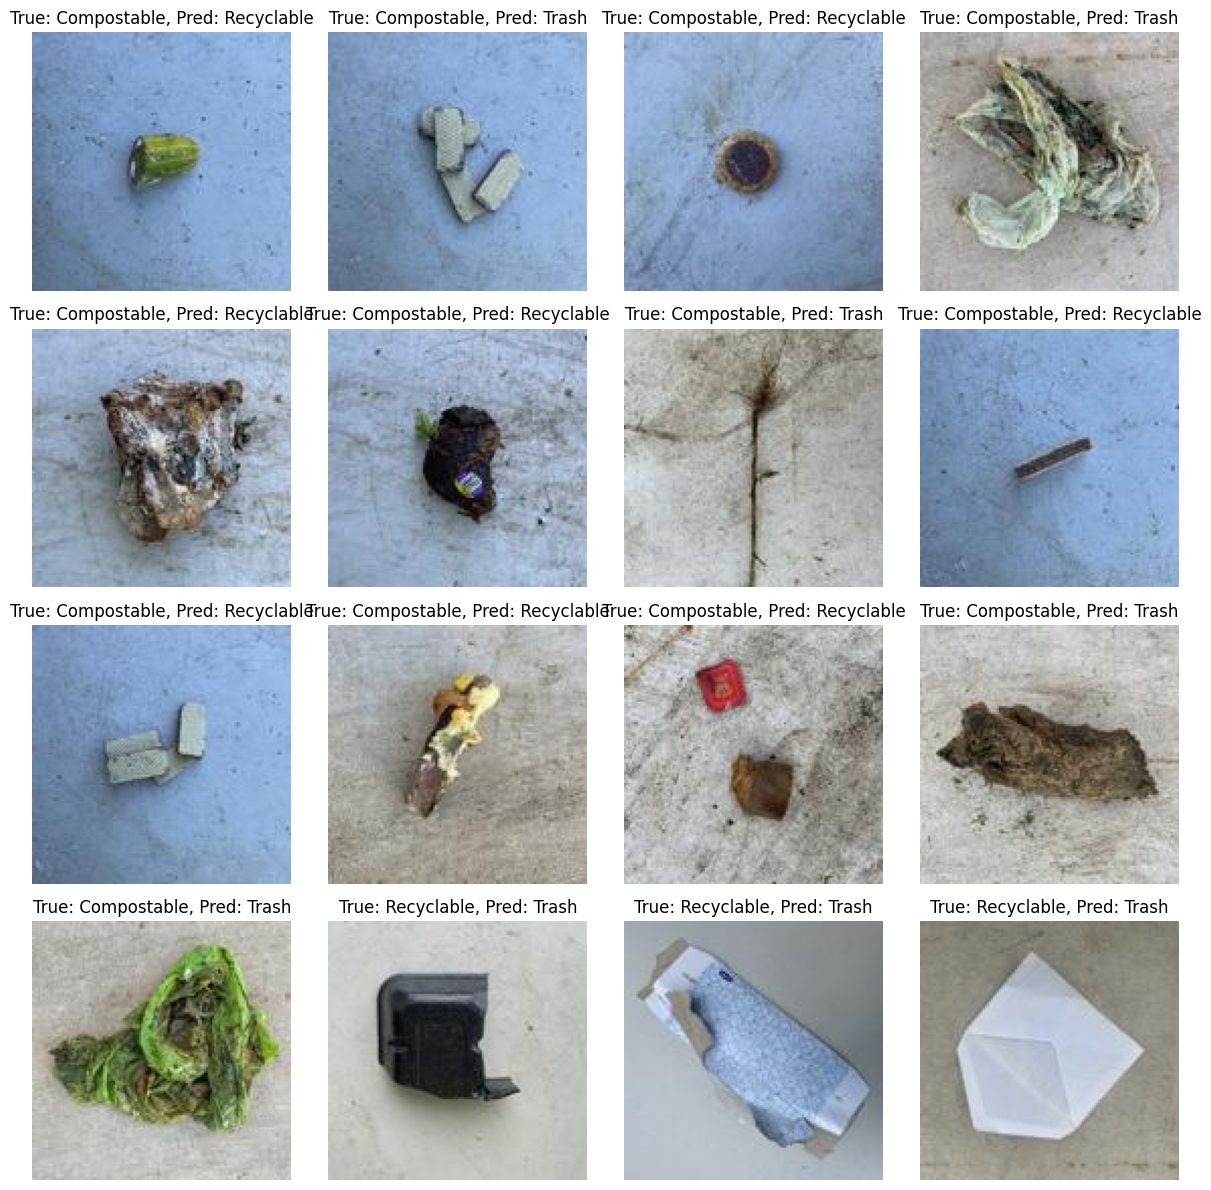

In [40]:
# Visualize misclassified images
import matplotlib.pyplot as plt

misclassified_indices = np.where(true_labels != predicted_labels)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:16]):  # Show up to 16 examples
    plt.subplot(4, 4, i + 1)
    img = test_data.filepaths[idx]
    img_array = plt.imread(img)
    plt.imshow(img_array)
    plt.title(f"True: {class_names[true_labels[idx]]}, Pred: {class_names[predicted_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


#Creating Class Activation Maps for Missclassified images

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


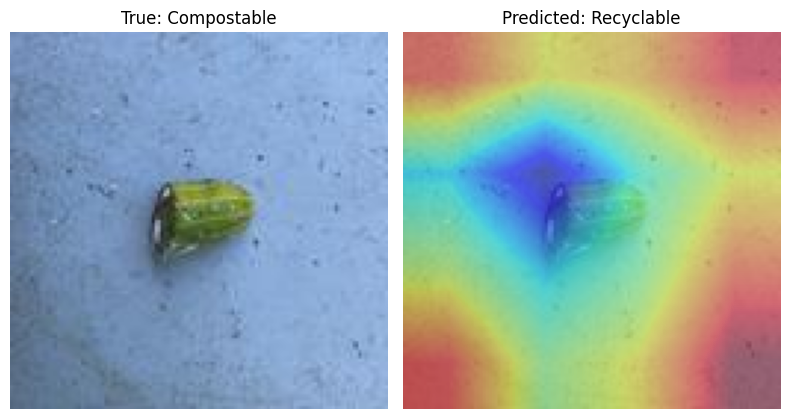

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


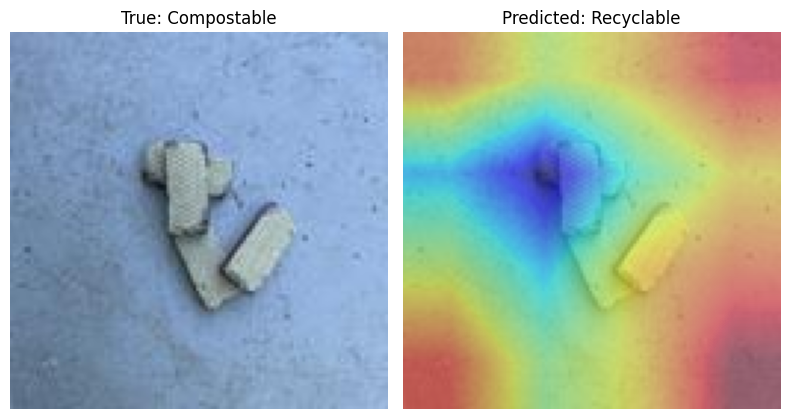

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


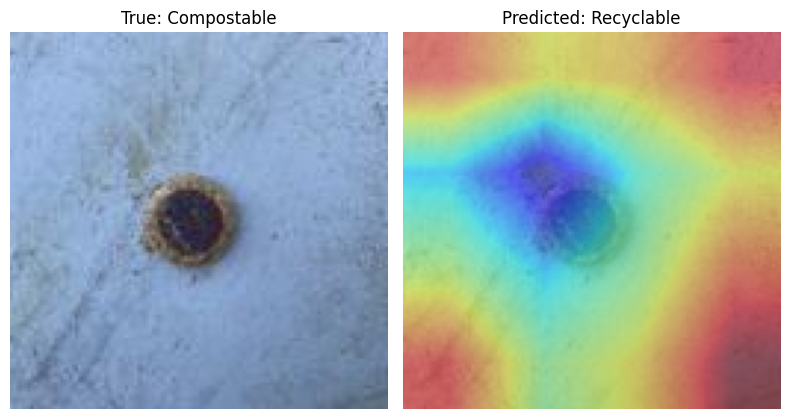

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


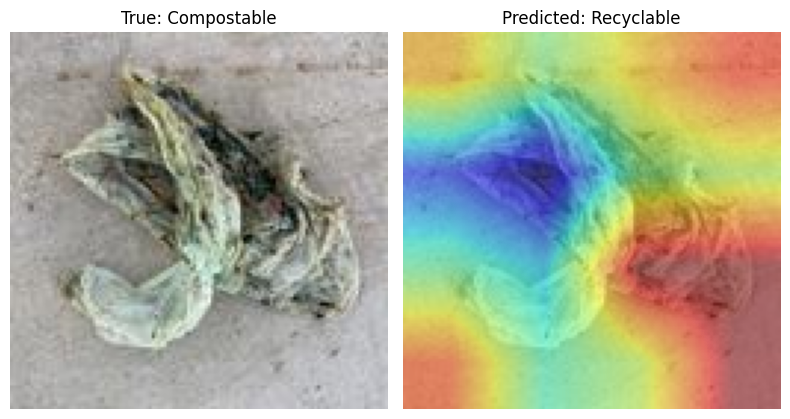

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


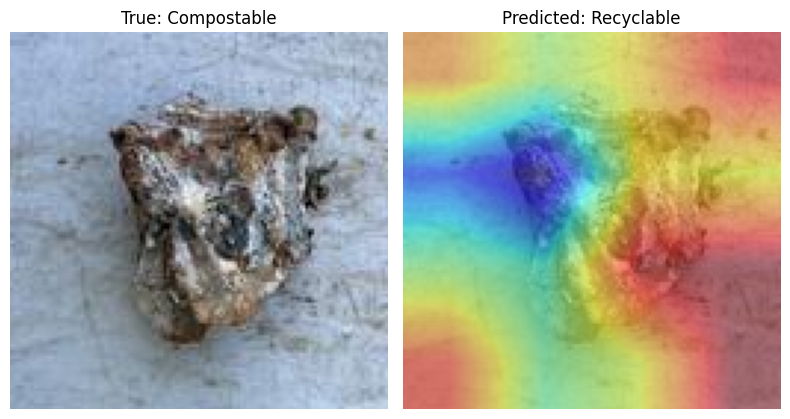

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2

# Define a function to generate CAMs
def generate_cam(model, image, true_label, class_names):
    # Identify the last convolutional layer
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that outputs the feature maps and predictions
    cam_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # Preprocess the image
    img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    img_array = np.expand_dims(img / 255.0, axis=0)  # Normalize and expand dimensions

    # Get the feature maps and predictions
    feature_maps, predictions = cam_model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Get weights of the last dense layer
    weights = model.layers[-1].weights[0].numpy()  # Shape: (num_filters, num_classes)

    # Compute the weighted sum of the feature maps
    cam = np.zeros(feature_maps[0].shape[:2], dtype=np.float32)  # Initialize CAM
    for i, w in enumerate(weights[:, predicted_class]):  # Loop through all filters
        cam += w * feature_maps[0][:, :, i]  # Weighted sum

    # Normalize CAM
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))  # Resize to original image size
    cam = np.maximum(cam, 0)  # ReLU (only positive activations)
    if cam.max() > 0:
      cam = cam / cam.max()  # Normalize to 0-1
    else:
      cam = np.zeros_like(cam)  # Default to zeros if no activation


    return cam, predicted_class


# Plot the CAM overlaid on the original image
def plot_cam(image, cam, true_label, predicted_label, class_names):
    plt.figure(figsize=(8, 8))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"True: {class_names[true_label]}")
    plt.axis('off')

    # Overlay CAM
    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Overlay CAM
    plt.title(f"Predicted: {class_names[predicted_label]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate CAMs for misclassified images
for idx in misclassified_indices[:5]:  # Visualize first 5 misclassified images
    img_path = test_data.filepaths[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cam, pred_class = generate_cam(model, img, true_labels[idx], class_names)
    plot_cam(img, cam, true_labels[idx], pred_class, class_names)


#Training with more Epochs

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

# Use the previously configured SGD optimizer
sgd_optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model (reusing the SGD configuration)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Early stopping patience
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Reduce LR if no improvement for 5 epochs
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    'best_model_sgd_extended.keras',
    save_best_only=True,
    monitor='val_loss'
)

# Train the model with extended epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Increase epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.9362 - loss: 0.1676 - val_accuracy: 0.9336 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step - accuracy: 0.9524 - loss: 0.1356 - val_accuracy: 0.9326 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 248ms/step - accuracy: 0.9489 - loss: 0.1398 - val_accuracy: 0.9347 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9529 - loss: 0.1228 - val_accuracy: 0.9347 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9574 - loss: 0.1214 - val_accuracy: 0.9326 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9533 - loss: 0.1147 - val_accuracy: 0.9336 - val_loss: 0.2453 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9580 - loss: 0.

In [43]:
model.save('final_model_sgd_extended.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


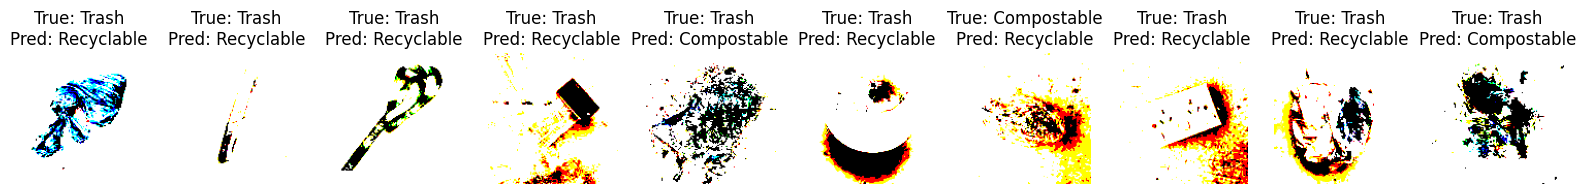

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def show_misclassified_images(model, data_generator, class_names, num_samples=20):
    """Display a few misclassified images."""
    misclassified_images = []
    true_labels = []
    pred_labels = []

    for i in range(len(data_generator)):
        images, labels = next(data_generator)
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        for j in range(len(images)):
            if true_classes[j] != predicted_classes[j]:
                misclassified_images.append(images[j])
                true_labels.append(true_classes[j])
                pred_labels.append(predicted_classes[j])

            if len(misclassified_images) >= num_samples:
                break
        if len(misclassified_images) >= num_samples:
            break

    # Plot the misclassified images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    for i in range(len(misclassified_images)):
        ax = axes[i]
        ax.imshow(misclassified_images[i])
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        ax.axis("off")

# Ensure the validation data generator is used correctly
show_misclassified_images(
    model=model,
    data_generator=val_data,  # Correctly use your validation data
    class_names=list(train_data.class_indices.keys()),  # Class names from generator
    num_samples=10
)


#Playing around with class weights & callbacks

#

In [45]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

# Train the model with the computed class weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Use early stopping as needed
    class_weight=class_weights_dict,  # Pass computed class weights
    callbacks=[early_stopping, reduce_lr]  # Ensure callbacks are defined
)


Class Weights: {0: 1.8697148475909537, 1: 0.5123955807060092, 2: 1.9472606246799795}
Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.9645 - loss: 0.1215 - val_accuracy: 0.9410 - val_loss: 0.2201 - learning_rate: 2.5000e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.9577 - loss: 0.1213 - val_accuracy: 0.9410 - val_loss: 0.2106 - learning_rate: 2.5000e-04
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.9560 - loss: 0.1129 - val_accuracy: 0.9420 - val_loss: 0.2095 - learning_rate: 2.5000e-04
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.9536 - loss: 0.1163 - val_accuracy: 0.9420 - val_loss: 0.2082 - learning_rate: 2.5000e-04
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9497 - loss: 0.1373 - val_accuracy: 0.9410 - val_loss: 0.2089 - learning_rate: 2.5000e-04
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.9549 - loss: 0.1170 - val_accuracy: 0.9399 - val_loss: 0.2072 -

In [46]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9803 - loss: 0.0567
Test Accuracy: 0.9707, Test Loss: 0.0904


In [47]:
model.save('final_model_finetuned_classweights.keras')

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9467 - loss: 0.1343 - val_accuracy: 0.9410 - val_loss: 0.2143 - learning_rate: 6.2500e-05
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - accuracy: 0.9543 - loss: 0.1198 - val_accuracy: 0.9410 - val_loss: 0.2222 - learning_rate: 6.2500e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.9580 - loss: 0.1171 - val_accuracy: 0.9410 - val_loss: 0.2281 - learning_rate: 6.2500e-05
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.9561 - loss: 0.1242 - val_accuracy: 0.9420 - val_loss: 0.2325 - learning_rate: 6.2500e-05
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.9580 - loss: 0.1252 - val_accuracy: 0.9410 - val_loss: 0.2348 - learning_rate: 6.2500e-05
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9591 - loss: 0.1123
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy:

In [49]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9818 - loss: 0.0542
Test Accuracy: 0.9716, Test Loss: 0.0909


In [50]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Lower reduction factor
    patience=10,  # More patience
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # You can increase this if necessary
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9528 - loss: 0.1306 - val_accuracy: 0.9410 - val_loss: 0.2178 - learning_rate: 3.1250e-05
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.9550 - loss: 0.1128 - val_accuracy: 0.9410 - val_loss: 0.2204 - learning_rate: 3.1250e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.9562 - loss: 0.1179 - val_accuracy: 0.9410 - val_loss: 0.2233 - learning_rate: 3.1250e-05
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9537 - loss: 0.1279 - val_accuracy: 0.9399 - val_loss: 0.2254 - learning_rate: 3.1250e-05
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - accuracy: 0.9614 - loss: 0.1078 - val_accuracy: 0.9399 - val_loss: 0.2279 - learning_rate: 3.1250e-05
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9583 - loss: 0.1176 - val_accuracy: 0.9399 - val_loss: 0.2307 - learning_rate: 3.1250e-05
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - acc

In [51]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9822 - loss: 0.0534
Test Accuracy: 0.9716, Test Loss: 0.0915


In [52]:
model.save('final_model_finetuned_classweights_reducedlr.keras')

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Recompute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

print(f"Updated Class Weights: {class_weights}")

# Train with updated weights
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)


Updated Class Weights: {0: 1.8697148475909537, 1: 0.5123955807060092, 2: 1.9472606246799795}
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9625 - loss: 0.1163 - val_accuracy: 0.9410 - val_loss: 0.2171 - learning_rate: 3.1250e-05
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9537 - loss: 0.1224 - val_accuracy: 0.9420 - val_loss: 0.2164 - learning_rate: 3.1250e-05
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9541 - loss: 0.1196 - val_accuracy: 0.9410 - val_loss: 0.2153 - learning_rate: 3.1250e-05
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - accuracy: 0.9464 - loss: 0.1297 - val_accuracy: 0.9420 - val_loss: 0.2146 - learning_rate: 3.1250e-05
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9516 - loss: 0.1185 - val_accuracy: 0.9410 - val_loss: 0.2139 - learning_rate: 3.1250e-05
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.9506 - loss: 0.1336 - val_accuracy: 0.9410 - val_loss: 

In [54]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9822 - loss: 0.0537
Test Accuracy: 0.9716, Test Loss: 0.0913


In [55]:
model.save('final_model_finetuned_classweights_reducedlr_updated.keras')